In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
from data_processing import generate_dataset_from_pgn, label_to_move_table, fen_to_board_tensor
import chess
import random

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

dataset = generate_dataset_from_pgn("../pgn_files/LumbrasGigaBase_OTB_2020-2024.pgn", max_games=10000)



Using device: NVIDIA GeForce RTX 3050


In [ ]:
# print(dataset[175])

# for i in range(10):
#     print(i, dataset[i+175][2])

wins = []
for _,_,w in dataset[:20000]:
    wins.append(w)

print("counts:", wins.count(1), wins.count(-1), wins.count(0))
print(wins[:40])

counts: 6653 6618 6729
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
train_to_test_ratio = 0.8

train_size = int(len(dataset) * train_to_test_ratio)
test_size = len(dataset) - train_size

# split the dataset
train_data = dataset[:train_size]
test_data = dataset[train_size:]

print(train_data[99428])

X_train = torch.stack([board for board, move, winner in train_data])  # (N, 8, 8, 12)
t_train = torch.tensor([(move, winner) for board, move, winner in train_data])  # (N, 2)

X_test = torch.stack([board for board, move, winner in test_data])
t_test = torch.tensor([(move, winner) for board, move, winner in test_data])
# create DataLoaders
batch_size = 256
train_dataset = TensorDataset(X_train, t_train)
test_dataset = TensorDataset(X_test, t_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 0., 0., 0.],
      

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            channels, channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(
            channels, channels, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class SLPolicyValueNetwork(nn.Module):
    def __init__(self, blocks=10, channels=256, num_possible_moves=20480):
        super(SLPolicyValueNetwork, self).__init__()

        # shared trunk
        self.conv1 = nn.Conv2d(
            in_channels=13, out_channels=channels, kernel_size=3, padding=1 # padding=1 for same size output
        )

        self.norm = nn.BatchNorm2d(channels)

        self.blocks = nn.ModuleList(
            [ResNetBlock(channels) for _ in range(blocks)]
        )

        self.fc_shared = nn.Linear(channels * 8 * 8, 512)

        # policy head
        self.fc_policy = nn.Linear(512, num_possible_moves)

        # value head
        self.value_conv = nn.Conv2d(channels, 1, 1)
        self.value_bn = nn.BatchNorm2d(1)
        self.value_fc1 = nn.Linear(8 * 8, 256)
        self.value_fc2 = nn.Linear(256, 1)


    def forward(self, x):
        # x = x.permute(0, 3, 1, 2) #conv2d expects (batch, channels, height, width)
        x = F.relu(self.conv1(x))
        conv_out = self.norm(x)

        for block in self.blocks:
            conv_out = block(conv_out)

        # policy head
        policy_flat = torch.flatten(conv_out, start_dim=1)  # exclude batch dimension
        policy_features = F.relu(self.fc_shared(policy_flat))
        policy_logits = self.fc_policy(policy_features)

        # value head
        v = F.relu(self.value_bn(self.value_conv(conv_out)))
        v = v.view(v.size(0), -1)
        v = F.relu(self.value_fc1(v))
        value = torch.tanh(self.value_fc2(v))


        return policy_logits, value


model = SLPolicyValueNetwork().to(device)
# model.load_state_dict(torch.load("sl_policy_network_KC.pth", map_location=torch.device("cpu")))
policy_criterion = nn.CrossEntropyLoss() # softmax regression loss function
value_criterion = nn.MSELoss() # use to use logistic loss but expects labels to be 0 or 1, not a range betwen -1 and 1
optimizer = optim.Adam(model.parameters(), lr=0.1e-4)

model.train()

NameError: name 'device' is not defined

In [ ]:
# checkpoint = torch.load("checkpoint2.pth")
# model.load_state_dict(checkpoint["model"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# start_epoch = checkpoint["epoch"]
# start_batch = checkpoint["batch"]
start_epoch = 0
start_batch = 0

print(f"Resuming from epoch {start_epoch}, batch {start_batch}")

epochs = 20

for epoch in range(epochs):

    epoch = start_epoch + epoch
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data = data.to(device)
        batch_move_target = target[:, 0].to(device)
        batch_val_target = target[:, 1].float().unsqueeze(1).to(device)

        pred_policy, pred_val = model(data)  # calculate predictions for this batch
        policy_loss = policy_criterion(pred_policy, batch_move_target)  # calculate loss for policy
        value_loss = value_criterion(pred_val, batch_val_target) # calculate loss for value
        loss = policy_loss + value_loss
        optimizer.zero_grad()  # reset gradient
        loss.backward()  # calculate gradient
        optimizer.step()  # update parameters

        if batch_idx % 100 == 0:
            print(f"batch progress: epoch {epoch+1} {(100 *(batch_idx +1)/len(train_dataloader)):.2f}% loss: {loss.item():.6f}")
            # torch.save({
            #     "model": model.state_dict(),
            #     "optimizer": optimizer.state_dict(),
            #     "epoch": epoch+1, 
            #     "batch": batch_idx,
            # }, "checkpoint2.pth")

        print(f"batch progress: epoch {epoch+1} {(100 *(batch_idx +1)/len(train_dataloader)):.2f}% loss: {loss.item():.6f}")
        # torch.save({
        #     "model": model.state_dict(),
        #     "optimizer": optimizer.state_dict(),
        #     "epoch": epoch+1,
        #     "batch": batch_idx,
        # }, "checkpoint2.pth")

    # check validation accuracy to see if general patterns are being learnt

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_dataloader):
            data = data.to(device)
            batch_move_target = target[:, 0].to(device)
            batch_val_target = target[:, 1].float().unsqueeze(1).to(device)

            pred_policy, pred_val = model(data)
            policy_loss = policy_criterion(pred_policy, batch_move_target)  # calculate loss for policy
            value_loss = value_criterion(pred_val, batch_val_target) # calculate loss for value
            loss = policy_loss + value_loss
            test_loss += loss

    print('epoch: {}, test loss: {:.6f}'.format(
        epoch + 1,
        test_loss / len(test_dataloader),
        ))
    
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch+1, 
        "batch": batch_idx,
    }, "checkpoint2.pth")
    print('model checkpoint saved')
    
    model.train()

Resuming from epoch 0, batch 0
batch progress: epoch 1 0.04% loss: 4.988117
batch progress: epoch 1 0.04% loss: 4.988117
batch progress: epoch 1 0.09% loss: 5.268795
batch progress: epoch 1 0.13% loss: 5.344055
batch progress: epoch 1 0.18% loss: 5.332375
batch progress: epoch 1 0.22% loss: 5.301333
batch progress: epoch 1 0.27% loss: 5.044466
batch progress: epoch 1 0.31% loss: 5.331589
batch progress: epoch 1 0.36% loss: 5.469030
batch progress: epoch 1 0.40% loss: 5.188814
batch progress: epoch 1 0.45% loss: 5.439556
batch progress: epoch 1 0.49% loss: 5.311732
batch progress: epoch 1 0.54% loss: 5.547942
batch progress: epoch 1 0.58% loss: 5.631670
batch progress: epoch 1 0.62% loss: 5.074471
batch progress: epoch 1 0.67% loss: 4.983937
batch progress: epoch 1 0.71% loss: 5.175117
batch progress: epoch 1 0.76% loss: 5.126433
batch progress: epoch 1 0.80% loss: 5.230248
batch progress: epoch 1 0.85% loss: 5.091990
batch progress: epoch 1 0.89% loss: 5.293658
batch progress: epoch 1 

In [ ]:
torch.save(model.state_dict(), "sl_policy_value_network5.pth")

In [15]:
game_state = chess.Board()
board = game_state.fen()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SLPolicyValueNetwork().to(device)
model.load_state_dict(torch.load("sl_policy_value_network4.pth", map_location=torch.device("cuda")))

<All keys matched successfully>

In [13]:
model(fen_to_board_tensor(board).unsqueeze(0).to(device))

(tensor([[-11.4847, -13.2326, -12.0231,  ..., -11.7465, -11.9123, -13.1137]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.0012]], device='cuda:0', grad_fn=<TanhBackward0>))

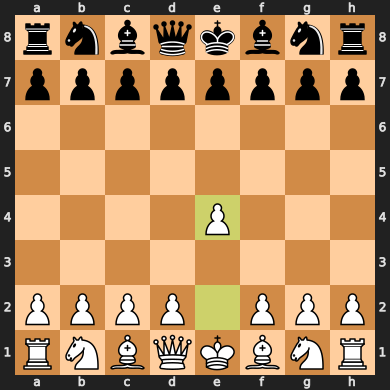

In [20]:
game_state.copy()

In [9]:

def predict_move(model, board_tensor):
    """
    Takes a board tensor (13, 8, 8) and returns the predicted UCI move.
    """
    label_to_uci = label_to_move_table()
    model.eval()  # Set to evaluation mode
    

    with torch.no_grad():  # no gradients needed for inference
        # add batch dimension to fit model params: (8, 8, 12) -> (1, 8, 8, 12)
        board_batch = board_tensor.unsqueeze(0).to(device)

        # Get model output
        logits, val = model(board_batch)  # Shape: (1, 20480)
        probabilities = F.softmax(logits, dim=1)

        # Get the highest scoring move
        predicted_label = torch.argmax(probabilities, dim=1).item()

        # Convert to UCI
        predicted_uci = label_to_uci[predicted_label]

    return predicted_uci, val


def list_predicted_moves(model, board_tensor, num_moves):
    label_to_uci = label_to_move_table()

    model.eval()
    with torch.no_grad():
        board_batch = board_tensor.unsqueeze(0).to(device)
        logits, val = model(board_batch)  
        probabilities = F.softmax(logits, dim=1)
        score, moves = torch.topk(probabilities, num_moves)
        moves = [label_to_uci[int(move)] for move in moves[0]]
        

    return moves, val

def predict_move_with_depth(model, fen, depth):
    """
    Predicts the best move by looking ahead a certain depth using the model.
    """
    model.eval()
    is_maximizing = True
    if fen.split()[1] == 'b':
        is_maximizing = False

    board = chess.Board()
    board.set_board_fen(fen.split()[0])

    def minmax(board, depth, is_maximizing):
        print(board)

        if depth == 0 or board.is_game_over():
            board_tensor = fen_to_board_tensor(board.fen())
            _, value = predict_move(model, board_tensor)
            return value.item()

        if is_maximizing:
            best_value = float(('-inf'))
            for move in board.legal_moves:
                board.push(move) #make temp move
                value = minmax(board, depth - 1, False)
                board.pop() #undo temp move
                best_value = max(best_value, value)
            return best_value
        else:
            best_value = float('inf')
            for move in board.legal_moves:
                board.push(move)
                value = minmax(board, depth - 1, True)
                board.pop()
                best_value = min(best_value, value)
            return best_value
    
    best_value = float(('inf'))
    best_move = None
    if is_maximizing:
        best_value = float(('-inf'))

    for move in board.legal_moves:
        board.push(move)
        move_value = minmax(board, depth - 1, is_maximizing=is_maximizing)
        board.pop()

        if move_value > best_value:
            best_value = move_value
            best_move = move

    return best_move.uci()



In [10]:
def eval_from_fen(model, fen):
    
    board_tensor = fen_to_board_tensor(fen)
    move, value =  predict_move(model, board_tensor)

    # print("raw value:", value.item())

    if fen.split(" ")[1] == 'w':
        return move, value.item()
    else:
        return move, -value.item()


print(eval_from_fen(model, "4k3/8/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1")) #winning for white
print(eval_from_fen(model, "rnbqkbnr/pppppppp/8/8/8/8/8/4K3 w kq - 0 1")) #losing for white

# MODEL PREDICTS ILLEGAL MOVES

('e2e4', 0.3357652425765991)
('e1d2', -0.20028038322925568)


In [82]:
board = chess.Board()
moves_played = []
model_turn = 1

while not board.is_game_over():
    move = None
    if model_turn:
        print("model")

        board_tensor = fen_to_board_tensor(board.fen())
        moves, probs = list_predicted_moves(model, board_tensor, 20480)
        
        for move in moves:
            try:
                board.push_uci(move)
            except chess.IllegalMoveError:
                continue
            break
        model_turn = 0
    else:
        print("random")
        moves = board.legal_moves
        move_index = random.randint(0, moves.count()-1)
        moves = [move for move in moves]
        move = moves[move_index]
        board.push(move)
        model_turn = 1

    moves_played.append(move)
    print(board)
    print(len(moves_played))
    

model
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
1
random
r n b q k b n r
. p p p p p p p
p . . . . . . .
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
2
model
r n b q k b n r
. p p p p p p p
p . . . . . . .
. . . . . . . .
. . P . . . . .
. . N . . . . .
P P . P P P P P
R . B Q K B N R
3
random
r n b q k b n r
. p p p p . p p
p . . . . . . .
. . . . . p . .
. . P . . . . .
. . N . . . . .
P P . P P P P P
R . B Q K B N R
4
model
r n b q k b n r
. p p p p . p p
p . . . . . . .
. . . . . p . .
. . P . . . . .
. . N . . . P .
P P . P P P . P
R . B Q K B N R
5
random
r n b q k b n r
. p p . p . p p
p . . p . . . .
. . . . . p . .
. . P . . . . .
. . N . . . P .
P P . P P P . P
R . B Q K B N R
6
model
r n b q k b n r
. p p . p . p p
p . . p . . . .
. . . . . p . .
. . P . . . . .
. . N . . . P .
P P . P P P B P
R . B Q K . N R
7
random
r n b q k b . r
. p p . p . p p
p . . 

In [83]:

def export_game_from_board(board: chess.Board, file_name: str):
    game = chess.pgn.Game()
    game.headers["Event"] = "DEMO"
    game.headers["White"] = "ResNetPV"
    game.headers["Black"] = "random"
    game.headers["Result"] = board.result()

    # add moves to the game node
    node = game
    for move in board.move_stack:
        node = node.add_variation(move)

    # save to PGN file
    with open(f"{file_name}.pgn", "w", encoding="utf-8") as pgn_file:
        print(game, file=pgn_file)
    pgn_file.close()


In [84]:
export_game_from_board(board, "ResNetpv2_vs_random")